# 1. Introduction
<p>In this assignment, I have used H1B visa application dataset. H1B visa is a non-immigrant temporary work visa that lets people with special skills to work in USA. To apply for this visa, the applicant must have a job offer from an employer in the USA. The employer then files H1B visa petition with the US Immigration Service (USCIS) for the employee with relevant attestations, including attestations about wages and working conditions. After the approval from USCIS, this petition allows employee to obtain a visa stamp and work in the U.S. for that employer. I have chosen this dataset to discover the influence of attributes of user applicant on visa status. My goal is to develop an algorithm that can predict the petition outcome based on application information.</p>

<p>Since, I am planning to forecast the visa petition status, the outcome of the analysis is divided into two classes (Denied or Certified). Considering it as a binary classification problem, I have applied multiple model on this dataset. The report initially represents the analysis of available dataset by plotting relationship bettewn various attributes. In the   next   sections, the following  have  been  described  in  brief: data  processing, feature  selection,  implement of different  classification  models  on  the  available  data  and  its evaluation.</p>

# 2. Data Set and Features

The dataset comes from kaggle repository. It contains H-1B visa petition information from 2011-2016. It includes 10 columns with approximately 3 million rows. Here is the list of all columns:
<ol>
<li>**CASE_STATUS:**</li> this feature defines the final decision of application. It is divided into seven classes, CERTIFIED, CERTIFIED-WITHDRAWN, WITHDRAWN, DENIED, PENDING QUALITY AND COMPLIANCE REVIEW – UNASSIGNED, REJECTED, INVALIDATED. 
<li>**EMPLOYER_NAME:**</li> represents the company name who files the petition to recruit employee. 
<li>**SOC_NAME:**</li> states occupational name that is classified by the Standard Occupational Classification (SOC) System.
<li>**JOB_TITLE:**</li> Title of the job.
<li>**FULL_TIME_POSITION:**</li> represents job status where, Y= full time and N=part time.
<li>**PREVAILING_WAGE:**</li> defines the average wage paid to similarly employed workers in the requested occupation in the area of intended employment
<li>**YEAR:**</li> Year in which the visa petition filed
<li>**WORKSITE:**</li> The employee’s intended area of employment.
<li>**LON:**</li> longitude of the worksite.
<li>**LAT:**</li> latitude of the worksite.
</ol>

In [1]:
#import all the libraries 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas      as pd
import numpy       as np
import seaborn as sns
import re
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [2]:
#read the csv.file
data = pd.read_csv("h1b_kaggle.csv",index_col=0)

C:\Users\eruba\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#no of rows and columns in dataset
print('No of rows and columns: ',data.shape)
print('\n Total no of entry in each column: \n', data.count())
print('Types of Data:\n',data.info())

#made a deep copy of dataset
cdf = data.copy()

No of rows and columns:  (3002458, 10)

 Total no of entry in each column: 
 CASE_STATUS           3002445
EMPLOYER_NAME         3002399
SOC_NAME              2984724
JOB_TITLE             3002415
FULL_TIME_POSITION    3002443
PREVAILING_WAGE       3002373
YEAR                  3002445
WORKSITE              3002458
lon                   2895216
lat                   2895216
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3002458 entries, 1 to 3002458
Data columns (total 10 columns):
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  float64
WORKSITE              object
lon                   float64
lat                   float64
dtypes: float64(4), object(6)
memory usage: 252.0+ MB
Types of Data:
 None


## 2.1 Data Exploration
After loading the dataset, it is important to explore it to see the structure and format of all variables or features. In this dataset, 6 variables are float and 4 variables are in object format. With the help of graphical representation, I am going to check the status of each variable. 
<p>**Missing Values:** From the following list and the heatmap, it is quiet clear that variable _lon_ and _lat_ has the highest number of missing values. *SOC_NAME* has the second most number of missing values. These values will be taken care of in data cleaning section.</p>

CASE_STATUS               13
EMPLOYER_NAME             59
SOC_NAME               17734
JOB_TITLE                 43
FULL_TIME_POSITION        15
PREVAILING_WAGE           85
YEAR                      13
WORKSITE                   0
lon                   107242
lat                   107242
dtype: int64


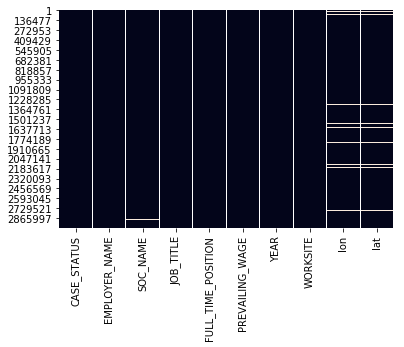

In [4]:
print(cdf.isnull().sum())
sns.heatmap(cdf.isnull(), cbar=False)

<p>**CASE_STATUS:** The frequency of result for the number of petition filed over the year is represented by a bar chart. The chart shows that number of certified visa status is way more than denied status. Number of withdrawl cases after certification is also huge. Whereas, *Pending*, *Rejection* and *Invalid* cases are quite low. As I will only classify between certified and denial cases, I will convert the categories into either denied or certified. </p>

<p>Since, *Rejection* and *Invalid* are both cases of a denied visa, I convert those case status to *Denied*. *Pending* is most likely to be rejected in case of US visa, so it should be changed to *Denied* as well. *Certified Withdrawn* decision is made by USCIS but then the employer or the applicant change it. That’s why, I merged it with *Certified* label. I removed data with *Withdrawn* label as it has no influence on USCIS’s decision. Finally the target variable have only 2 classes i.e. *Certified* and *Denied*. It is highly imbalanced dataset where number of *Denied* class is very low.</p>

In [5]:
cdf.CASE_STATUS.value_counts()

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64

In [6]:
case_status = {
   'CASE_STATUS': {
      r'(PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED|REJECTED|INVALIDATED)':'DENIED',
      r'CERTIFIED-WITHDRAWN': 'CERTIFIED'}
}
cdf.replace(case_status, regex=True, inplace=True)

# drop rows with 'WITHDRAWN' value 
indexNames = cdf[cdf['CASE_STATUS']=='WITHDRAWN'].index
cdf.drop(indexNames , inplace=True)

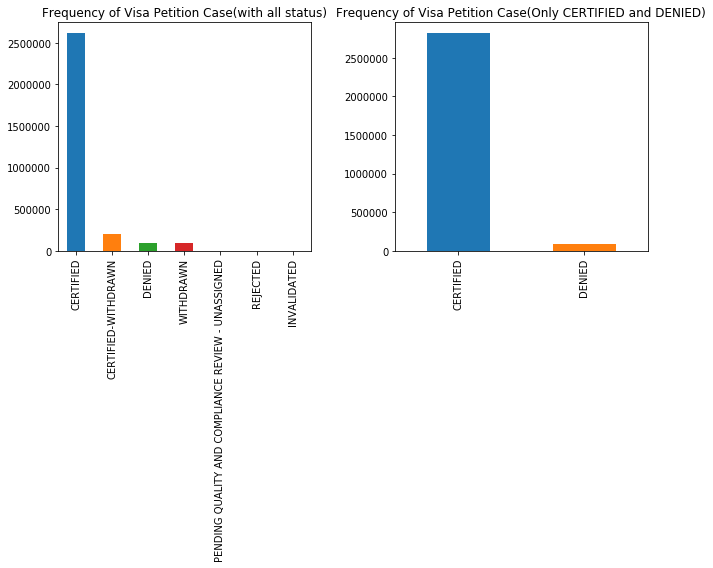

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
data['CASE_STATUS'].value_counts().plot(kind='bar',title='Frequency of Visa Petition Case(with all status)')
plt.subplot(1, 2, 2)
cdf['CASE_STATUS'].value_counts().plot(kind='bar',title='Frequency of Visa Petition Case(Only CERTIFIED and DENIED)')
plt.tight_layout()
plt.show()

**EMPLOYER_NAME and SOC_NAME:** In *EMPLOYER_NAME* column, number of unique value is 234089 and top company is Infosys Limited. Top five companies that file the most visa petition case is IT related according to following bar chart. 
<p> The number of unique value for *SOC_NAME* is also huge. The chart below displays that *Computer Analysts* is the top most job position for which people are recruited. </p>

In [8]:
print('Summary of EMPLOYER_NAME column: ',cdf.EMPLOYER_NAME.describe())
print('Summary of SOC_NAME column: : ',cdf.SOC_NAME.describe())

Summary of EMPLOYER_NAME column:  count             2912628
unique             234089
top       INFOSYS LIMITED
freq               130317
Name: EMPLOYER_NAME, dtype: object
Summary of SOC_NAME column: :  count                       2895573
unique                         2108
top       Computer Systems Analysts
freq                         284987
Name: SOC_NAME, dtype: object


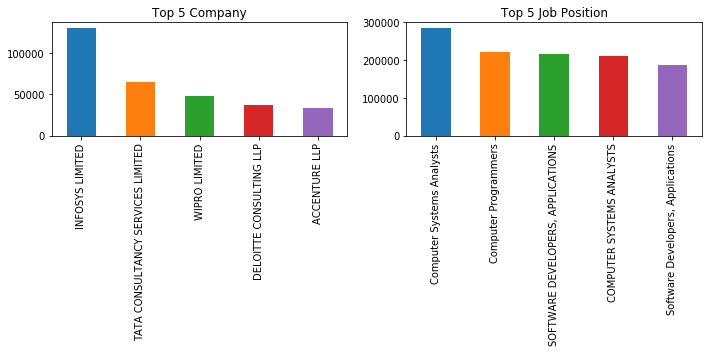

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
cdf.EMPLOYER_NAME.value_counts().head(5).plot(kind='bar',title='Top 5 Company')
plt.subplot(1, 2, 2)
cdf.SOC_NAME.value_counts().head(5).plot(kind='bar',title='Top 5 Job Position')
plt.tight_layout()
plt.show()

**PREVAILING_WAGE:** In *PREVAILING_WAGE* column, minimum salary is 0.0 where, maximum is 6000 million. Median value is 65000.0 but mean is 142891. It can be seen that there is extrem difference between the minimum and maximum value. So, it is clear that multiple outliers exist in the dataset. From the box plot of 500 rows of data, it shows the existence of outlier. Interestingly, in case_status vs wage plot, more outlier is identified in denial cases.

In [12]:
print('Median: ',np.nanmedian(cdf.PREVAILING_WAGE))
print('Mean: ',np.nanmean(cdf.PREVAILING_WAGE))

cdf.PREVAILING_WAGE.describe()

Median:  65000.0
Mean:  142891.0350401751


count    2.912593e+06
mean     1.428910e+05
std      5.282312e+06
min      0.000000e+00
25%      5.441300e+04
50%      6.500000e+04
75%      8.143200e+04
max      6.997607e+09
Name: PREVAILING_WAGE, dtype: float64

C:\Users\eruba\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 720x576 with 0 Axes>

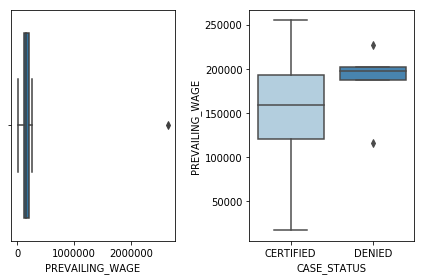

In [13]:
plt.figure(figsize=(10,8))
fig, ax =plt.subplots(1,2)
sns.boxplot(x=data.PREVAILING_WAGE.head(500),ax=ax[0])
sns.boxplot(x="CASE_STATUS", y="PREVAILING_WAGE", data=cdf.head(100),palette="Blues",ax=ax[1])
plt.tight_layout()
fig.show()

In following density plot, it shows the trend of wage pattern over the year from 2011-2016. All the patterns are right skewed and indicate a number of outliers.

C:\Users\eruba\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\eruba\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


(0, 500000000)

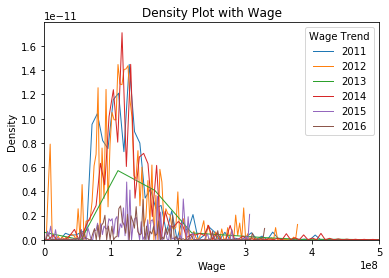

In [14]:
years = [2011, 2012, 2013,2014,2015,2016]

# Iterate through the five airlines
for year in years:
    # Subset to the airline
    subset = data[data['YEAR'] == year]
    # Draw the density plot
    sns.distplot(subset['PREVAILING_WAGE'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = year)    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Wage Trend')
plt.title('Density Plot with Wage')
plt.xlabel('Wage')
plt.ylabel('Density')
plt.xlim(0,500000000)

**WORKSITE:** In this column, total unique city is 18189. New York is the top city from where most of the visa petition has been filed. 

In [15]:
cdf.WORKSITE.describe()

count                2912659
unique                 18189
top       NEW YORK, NEW YORK
freq                  185817
Name: WORKSITE, dtype: object

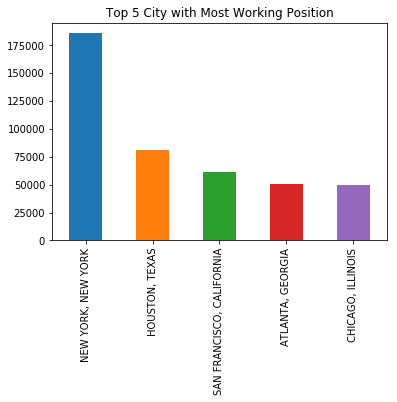

In [16]:
cdf.WORKSITE.value_counts().head(5).plot(kind='bar',title='Top 5 City with Most Working Position')

## 2.2 Data Preprocessing
- **Missing Value Handling:** From previous section, it is clear that *lon* and *lat* variable has the most missing values. These two variables indicate the location of employer. As I am going to use *WORKSITE* variable for this purpose, I will drop these columns. Moreover, *JOB_TITLE* and *SOC_NAME* are both indicated the job title which can be represented by any of these columns. That's why I have removed the *JOB_TITLE* column as well. After that, if there is any row with NAN value, I am going to drop them as well.

In [17]:
#drop JOB_TITLE, lattitude and longitutde
cdf.drop('JOB_TITLE',inplace=True,axis=1)
cdf.drop('lon',inplace=True,axis=1)
cdf.drop('lat',inplace=True,axis=1)

In [18]:
cdf.dropna(inplace=True)

- **Imbanalnced Class:** In this dataset, the target(*CASE_STATUS*) variable have 2818282 *Certified* and 94364 *Denied* cases which makes this dataset highly imbalanced. It can influence the classification task. To make it balance, I have downsampled the *Certified* cases to the count of the *Denied* cases. 

In [19]:
#Down sampling
class_certified, class_denied = cdf.CASE_STATUS.value_counts()
# Divide by class
cdf_class_c = cdf[cdf.CASE_STATUS=='CERTIFIED']
cdf_class_d = cdf[cdf.CASE_STATUS=='DENIED']

seed=7
cdf_class_c_under =cdf_class_c.sample(class_denied,random_state=seed)
cdf_down = pd.concat([cdf_class_c_under, cdf_class_d], axis=0)

print('Random under-sampling:')
print(cdf.CASE_STATUS.value_counts())

Random under-sampling:
CERTIFIED    2801722
DENIED         93782
Name: CASE_STATUS, dtype: int64


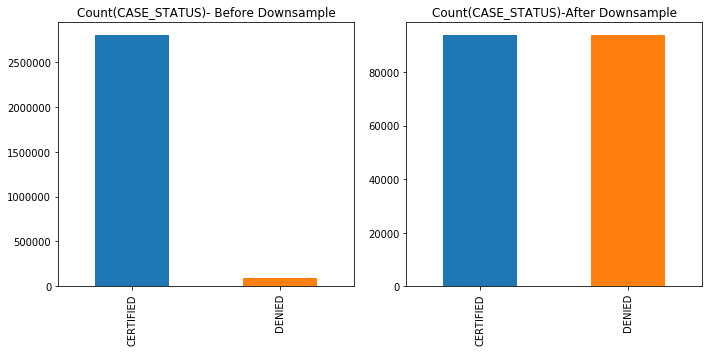

In [20]:
#Graph before after down sampling
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
cdf['CASE_STATUS'].value_counts().plot(kind='bar', title='Count(CASE_STATUS)- Before Downsample');
plt.subplot(1, 2, 2)
cdf_down.CASE_STATUS.value_counts().plot(kind='bar', title='Count(CASE_STATUS)-After Downsample');
plt.tight_layout()
plt.show()

- **Outlier:** I have checked *PREVAILING_WAGE* if there was any outliers affecting the dataset. In most of the cases, petitions have a wage in the range between 40k and 80k US Dollars. There are certain petitions with wages of more than 500k, and some with 0 dollars. Since these are very extreme cases, they should be treated as outliers. I have used IQR test to find the outlier that is if data point is above the third quartile or below the first quartile it should be removed. Finally, I have replaced the NA value with mean.

In [21]:
## Feature: Wage
#detect outlier in PREVAILING_WAGE
q1 = cdf_down["PREVAILING_WAGE"].quantile(0.25)
q3 = cdf_down["PREVAILING_WAGE"].quantile(0.75)
IQR = q3 - q1
outliers = ((cdf_down["PREVAILING_WAGE"] < (q1 - 1.5 * IQR)) | (cdf_down["PREVAILING_WAGE"] > (q3 + 1.5 * IQR))).sum()
print('No of outliers: ', outliers)

No of outliers:  9696


In [22]:
# drop outlier 
cdf_down = cdf_down.drop(cdf_down[cdf_down.PREVAILING_WAGE < (q1 - 1.5 * IQR)].index)
cdf_down = cdf_down.drop(cdf_down[cdf_down.PREVAILING_WAGE > (q1 + 1.5 * IQR)].index)

After capping the wages with second quartile and third quartile, the mean and median are very similar. The following density plot shows a better distribution of data than without outlier.

C:\Users\eruba\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 720x576 with 0 Axes>

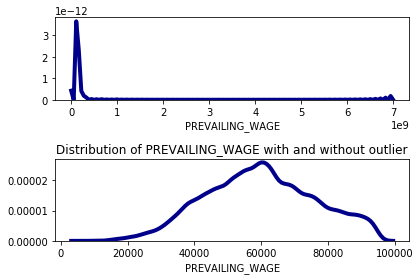

In [24]:
#plot density of PREVAILING_WAGE
plt.figure(figsize=(10,8))
fig, ax =plt.subplots(2,1)
plt.title('Distribution of PREVAILING_WAGE with and without outlier')
sns.distplot(cdf['PREVAILING_WAGE'], hist=False,kde=True,color='darkblue',kde_kws={'linewidth':4},ax=ax[0])
sns.distplot(cdf_down['PREVAILING_WAGE'], hist=False,kde=True,color='darkblue',kde_kws={'linewidth':4},ax=ax[1])
plt.tight_layout()
fig.show()

- **Data Cleaning and Filtering:** In *EMPLOYER_NAME* column, there are lot of unique employers. I removed the special characters and lowercase the name to uniform the format and enforce consistency. Inspite of that, it has got more than 500 categories. So I removed those employe name who filed less than 4 applications. 


In [25]:

cdf_down.EMPLOYER_NAME = cdf_down.EMPLOYER_NAME.str.lower()
emp_name = {
   'EMPLOYER_NAME': {
      r"[.\-,);\"'(+/]|(&QUOT;)":'', 
      r'ltd':'limited',
      r'(&amp;)|&':'and',r'(.*gates corporation.*$)':'gates corporation',
      r'corp$':'corporation',
      r'^europeanamerican':'european american',
      r'(.*euromarket designs inc.*$)':'euro market designs inc',
      r'(.*eurofins lancaster laboratories*$)':'eurofins lancaster laboratories inc',
      r'^eurocolletion|^eurocollection':'euro collection',
      r'^technosoft':'techno soft',
      r'^healthcare':'health care',
      r'^healthplan':'health plan',
      r'warner university inc':'warner university',
      r'grouppc$':'group pc',
      r'americasinc$':'americas inc'}
}

cdf_down.replace(emp_name, regex=True, inplace=True)


In [26]:
#Remove rows of the employers with less than 4 application  
cdf_dict = cdf_down.EMPLOYER_NAME.value_counts().to_dict()
emp_list = [k for k,v in cdf_dict.items() if v<=4]
len(emp_list)
cdf_down = cdf_down[~cdf_down.EMPLOYER_NAME.isin(emp_list)]

- <p>There are also many unique values in *SOC_NAME* column. I did the same special characters removal as *EMPLOYER_NAME*. I have created a dictionary to find out the data that are belonged to specific occupation section. I have created 13 categories for this purpose. Then put the values in **Other** category that have application number less than 5.
    </p>

In [33]:
# Feature 3: SOC_NAME
#remove special characters to uniform format
cdf_down['SOC_NAME']=cdf_down['SOC_NAME'].str.lower()
soc = {
   'SOC_NAME': {
      r"[*.\-,);\"'(+/]|<font>|</font>|(^[0-9]$)":'', r'&amp|&':' and ',
      r'^compute|^computer|^copmuter|^computers|^comuter|^compuer':'computer',
      r'induatrial':'industrial',
      r'engineers|enginers|engineering|engineerarquitects|enigneers|engineerarchitect':'engineer',
      r'analysta|analystt|analyhsts|analys$|anlysts':'analyst',
      r'sofware|softare|softwware':'software',
      r'^all other|all other$|other$|all othter$':'',
      r'systemanalyst':'system analyst',
      r'hardward':'hardware',
      r'aplications|applications|appllications|applicationsssss':'application',
      r'dvelopers|developers|developpers': 'developer',
      r'datebase':'database',
      r'maanger|mangers|managerse|managers':'manager', 
      r'sysems|systems':'system', 
      r'technicans|technicians':'technician',
      r'deisgners|designers':'designer',
      r'operations':'operation', 
      r'except computer non|except computer|except compuer':'', 
      r'software application developer|application developer':'software developer application'}                    
}

cdf_down.replace(soc, regex=True, inplace=True)
cdf_down=cdf_down[~cdf_down['SOC_NAME'].str.contains('^[0-9]*$',na=False)]

In [34]:
#Create dictionary to put the different job title in specific profession section
job_sector = {
   'SOC_NAME': {
      r".*agricultural(?s).*|.*maids(?s).*|.*cleaner(?s).*|.*bakers(?s).*|.*bartenders(?s).*|.*chefs(?s).*|.*butchers(?s).*|.*meat(?s).*|dishwashers|^laundry(?s).*|^funeral(?s).*|.*janitor(?s).*|^housekeeping(?s).*|^cook(?s).*|.*food(?s).*":'Food & Service', 
      r'^computer(?s).*|^information security(?s).*|^web developer(?s).*|^database(?s).*|^data warehousing(?s).*|^graphic(?s).*|^network and computer(?s).*|.*network system(?s).*|^software(?s).*|^information technology(?s).*':'IT Profession',
      r".*mathematician(?s).*|.*statisticians(?s).*|statistican|biostatisticians":'Mathematician',  
      r'.*survey(?s).*|.*school(?s).*|.*secondary school(?s).*|.*elementary school(?s).*|.*teachers(?s).*|.*postsecondary(?s).*|.*educators(?s).*|.*research assistants(?s).*|.*education(?s).*|.*translators(?s).*|.*training(?s).*|.*instructors(?s).*|.*instructional coordinators(?s).*':'Teaching',
      r'.*physician assistants(?s).*|.*orthodontists(?s).*|.*optometrists(?s).*|.*epidemiologists(?s).*|.*anesthesiologists(?s).*|.*rehabilitation(?s).*|.*dietitians(?s).*|.*nutritionists(?s).*|.*gynecologists(?s).*|.*mental(?s).*|.*health(?s).*|^biochemists(?s).*|^healthcare(?s).*|^health diagnosing(?s).*|.*pediatricians(?s).*|.*surgeons(?s).*|.*physical(?s).*|physicists|.*medical(?s).*|.*nurses(?s).*|.*pathologists(?s).*|.*practitioners$|.*psychiatrists(?s).*|veterinarians|pharmacists|^radiologists(?s).*|.*therapists(?s).*|neurologists|.*dentists(?s).*':'Medical',  
      r'.*loan(?s).*|.*property(?s).*|.*credit analysts(?s).*|.*financial(?s).*|^budget(?s).*|.*bill(?s).*|.*account(?s).*|.*accountants(?s).*|economists|^cost(?s).*|^statistical assistants(?s).*|^business operation specialists(?s).*|.*fiancial(?s).*':'Finance',
      r'.*aircraft(?s).*|.*operating engineer(?s).*|.*structural(?s).*|.*engineer(?s).*|.*electrical(?s).*|.*electronics(?s).*|.*designer(?s).*|.*architect(?s).*':'Architecture & Engineering',   
      r'.*biologist(?s).*|.*astronomers(?s).*|.*microbiologists(?s).*|.*biophysicist(?s).*|.*scienctists(?s).*|.*scientists(?s).*|chemists|^biological scientists $|^biomedical(?s).*':'Advance Science',
      r'.*manager(?s).*|operations research analysts|.*management(?s).*|chief executives|public relations specialists|logisticians|administrative services manager|.*planners(?s).*|human resources specialists|lodging manager|engineer manager':'Management',
      r'.*market(?s).*|.*marketing(?s).*|.*wholesale(?s).*|^sales(?s).*|^advertising(?s).*|compliance officers|.*salespersons$':'Marketing',
      r'.*judicial(?s).*|.*police(?s).*|.*law(?s).*|lawyers|.*judges(?s).*|.*attorney(?s).*|.*paralegals(?s).*|.*legal(?s).*':'Lawyer',
      r'.*technician(?s).*|.*operators(?s).*|.*technologists(?s).*':'Technician',
      r'.*audio(?s).*|.*photo(?s).*|.*recreation(?s).*|.*artists(?s).*|.*auditors(?s).*|.*athletic(?s).*|.*video(?s).*|.*writers(?s).*|.*music(?s).*|.*models(?s).*|composers|.*media(?s).*|singers|.*dancers(?s).*|poets and lyricists|coaches and scouts|.*sport(?s).*|.*fashion(?s).*|^media and communication workers$|^multimedia artists and animators|editors|^set designer$|^producers and directors$|^art directors$|^designer$|^reporters and correspondents$|.*entertainment(?s).*':'Fashion & Entertainment',
   } 
}
cdf_down.replace(job_sector, regex=True, inplace=True)

In [35]:
cdf_dict=cdf_down['SOC_NAME'].value_counts().to_dict()
soc_list = [k for k,v in cdf_dict.items() if v<=5]
len(soc_list)
cdf_down.SOC_NAME = np.where(cdf_down['SOC_NAME'].isin(soc_list), 'Others', cdf_down.SOC_NAME)

- *WORKSITE* represents employee’s intended area of employment. I split this column and consider city name only.

In [36]:
# Feature 8: WORKSITE
#select state as employer location
cdf_down['WORKSITE']=cdf_down['WORKSITE'].str.split(',',1).str[1].str.lower()


- **Convert Categorical Data:** These are the columns we now have in our dataset:
- Ordinal Values
    - PREVAILING_WAGE    
- Nominal Values:
    - CASE_STATUS
    - FULL_TIME_POSITION
    - EMPLOYER_NAME    
    - WORKSITE
<p>As *PREVAILING_WAGE* has huge number of unique values, I have divided it into three categories. The distribution is projected in following table:
    
                    |  **Range**    | **Category** |
                    |:-------------:|:------------:|
                    |    <30000     |      Low     |
                    | 30000>60000   |    Medium    |
                    |    60000>     |     High     |
    
    </p>
The conversion of other colums are shown in the table below:

                |       Column       |       Conversion      |
                |:------------------:|:---------------------:|
                |     CASE_STATUS    | CERTIFIED=1, DENIED=0 |
                | FULL_TIME_POSITION |        Y=1, N=0       |
                |    EMPLOYER_NAME   |       Dummy Data      |
                |      WORKSITE      |       Dummy Data      |

As four columns of dataset are in object format, I have changed them into category type to fit into the model.

In [37]:
#replace 'CERTIFIED' and 'DENIED' label of 'CASE_STATUS' respectively with '1' and '0'
cdf_down['CASE_STATUS'] = cdf_down['CASE_STATUS'].replace({'CERTIFIED': 1,'DENIED':0})
cdf_down.CASE_STATUS.astype(int)

640853     1
2205622    1
1702811    1
2848815    1
2614021    1
1617940    1
1941563    1
1473363    1
2555302    1
1760714    1
1975732    1
2529891    1
2807155    1
404481     1
285377     1
750377     1
1496115    1
1128489    1
1915805    1
1682969    1
2908138    1
1347191    1
955454     1
1460034    1
659669     1
1335880    1
2170024    1
2762586    1
1793193    1
2631966    1
          ..
3001840    0
3001956    0
3001959    0
3002005    0
3002009    0
3002047    0
3002059    0
3002101    0
3002117    0
3002201    0
3002227    0
3002257    0
3002262    0
3002291    0
3002292    0
3002298    0
3002309    0
3002315    0
3002321    0
3002324    0
3002328    0
3002331    0
3002337    0
3002347    0
3002348    0
3002354    0
3002355    0
3002357    0
3002365    0
3002368    0
Name: CASE_STATUS, Length: 83935, dtype: int32

In [38]:
#replace into 'low', 'medium' and 'high'
cdf_down['PREVAILING_WAGE'] = np.where((cdf_down['PREVAILING_WAGE'] > 0) & (cdf_down['PREVAILING_WAGE']<= 30000), 'low', np.where((cdf_down['PREVAILING_WAGE'] > 30000) & (cdf_down['PREVAILING_WAGE']<= 60000), 'medium', 'high'))

In [39]:
# Feature 5: FULL_TIME_POSITION
#replace 'Y' and 'N' label of 'FULL_TIME_POSITION' respectively with '1' and '0'
cdf_down['FULL_TIME_POSITION']=cdf_down['FULL_TIME_POSITION'].replace({'Y': 1, 'N': 0})
cdf_down.FULL_TIME_POSITION.astype(int)

640853     0
2205622    1
1702811    1
2848815    1
2614021    1
1617940    1
1941563    1
1473363    1
2555302    1
1760714    1
1975732    1
2529891    1
2807155    1
404481     1
285377     0
750377     1
1496115    1
1128489    1
1915805    1
1682969    1
2908138    1
1347191    1
955454     1
1460034    1
659669     1
1335880    1
2170024    1
2762586    1
1793193    1
2631966    1
          ..
3001840    1
3001956    1
3001959    1
3002005    1
3002009    1
3002047    1
3002059    1
3002101    1
3002117    1
3002201    1
3002227    1
3002257    1
3002262    1
3002291    1
3002292    0
3002298    1
3002309    0
3002315    1
3002321    1
3002324    1
3002328    1
3002331    1
3002337    1
3002347    1
3002348    1
3002354    1
3002355    1
3002357    1
3002365    1
3002368    1
Name: FULL_TIME_POSITION, Length: 83935, dtype: int32

In [41]:
type(cdf_down)
cdf_down[['EMPLOYER_NAME','SOC_NAME','WORKSITE','YEAR']] = cdf_down[['EMPLOYER_NAME','SOC_NAME','WORKSITE','YEAR']].apply(lambda x: x.astype('category'))


- **One Hot Encoding:** There are five categorical columns in this dataset after different conversion. I am using get_dummies() function to change the categorical data into numerical one. This pattern is also known as one hot encoding. 

In [42]:
categorical_col=['PREVAILING_WAGE','EMPLOYER_NAME','SOC_NAME','WORKSITE','YEAR']
dummy_df = pd.get_dummies(cdf_down[categorical_col])
cdf_down =pd.concat([cdf_down,dummy_df],axis=1)
cdf_down =cdf_down.drop(categorical_col,axis=1)

After cleaning and converting all the columns in the dataset, it shows that the missing value is zero and the data ready for training.

In [43]:
#no of missing value
cdf_down.isnull.sum()

AttributeError: 'function' object has no attribute 'sum'

In [ ]:
cdf_down.info()

# 3. Model
In this classification task, I am going to apply multiple method to find out the better one. I have used these three models here:
 <ol>
    <li>Logistic Regression </li>
    <li>Decision Tree </li>
    <li>Random Forest </li>
    </ol>
For this purpose, I split the dataset into two different portions: train set and test set. I will fit the model on train set. Then, evaluate it on the test set to find out the accuracy of the model. I have used 30% of total dataset as test set and 70% for training the model. I will use multiple model evaluation metrics to compare the result.

In [48]:
x = cdf_down.drop('CASE_STATUS', axis=1)
y = cdf_down.CASE_STATUS

seed = 7
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(58754, 4439) (58754,)
(25181, 4439) (25181,)


In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def roc_curve_graph(x_test,y_test,model):
    preds = model. predict_proba(x_test) [:,1]
    #Compute Receiver operating characteristic (ROC) curve
    fpr, tpr, threshold = roc_curve(y_test, preds)
    #ROC Score
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [50]:
def metrics_cal(x_test,y_test,prediction,model):    
    print("Model Accuracy:",metrics.accuracy_score(y_test, prediction))
    probs = model.predict_proba(x_test)
    roc_auc = metrics.roc_auc_score(y_test, probs[:,1]) 
    print("ROC:",roc_auc)
    print("Confusion Matrix:",metrics.confusion_matrix(y_test, prediction)) 
    print("Classification Report:", metrics.classification_report(y_test, prediction))  
    print("precision:",metrics.precision_score(y_test, prediction, pos_label=1))  
    print("Recall:",metrics.recall_score(y_test, prediction, pos_label=1))  
    print("F1 Score:",metrics.f1_score(y_test, prediction, pos_label=1))


In [51]:
from sklearn import metrics

def train_test_acc(model,x_train,y_train,x_test,y_test):
    print('Accuracy on training set: {:.2f}'
     .format(model.score(x_train, y_train)))
    print('Accuracy on test set: {:.2f}'
     .format(model.score(x_test, y_test)))
    

### 3.1 Logistic Regression
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In this task, CASE_STATUS is the dependable variable which will be predicted by logistic regression. I have used LogisticRegression() library to build the model on train set.
- **Result:** The accuracy of the model is: **75%**
- The **confusion matrix** depicts that we have 3100+15878 = **18978** correct predictions and 4742+ 1461= **6203** incorrect predictions.
- The **precision** is: **77%**
- The **recall** is : **92%**
- The **F-Score** score is: **0.84** which is close to 1. It indicates a good model. 
- The support is the number of occurrences of each class in y_test which is: **25181**.
- ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. In this model **Area Under the Curve** is **0.77** which is pretty good. **ROC-curve** shows that the model is better at distinguishing between petition with denied and certified status.

In [52]:
#Train Model
logit=LogisticRegression()
logit.fit(x_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
#Test Model
prediction=logit.predict(x_test)

Accuracy on training set: 0.79
Accuracy on test set: 0.75
Model Accuracy: 0.7536634764306421
ROC: 0.7683170430466209
Confusion Matrix: [[ 3100  4742]
 [ 1461 15878]]
Classification Report:              precision    recall  f1-score   support

          0       0.68      0.40      0.50      7842
          1       0.77      0.92      0.84     17339

avg / total       0.74      0.75      0.73     25181

precision: 0.7700290979631426
Recall: 0.9157390852990368
F1 Score: 0.8365868436997812


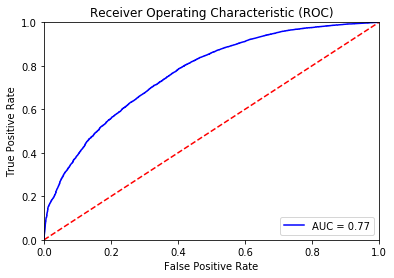

In [54]:
#Train-Test Accuracy
train_test_acc(logit,x_train,y_train,x_test,y_test)

#Metrics Calculation
metrics_cal(x_test,y_test,prediction,logit)

#ROC Curve create
roc_curve_graph(x_test,y_test,logit)


### 3.2 Decision Tree
In this model, the data is split into smaller subsets based on the best attribute. It uses branching method to create a branch for every possible decision. I have used DecisionTreeClassifier() library to build this model on train set. 

- **Result:** The **accuracy** of the model is: **74%** that is releatively low from previous model.
- The **confusion matrix** depicts that we have 3996+14572 = **18568** correct predictions and 3846+ 2767= **6612** incorrect predictions.
- The **precision** is: **79%**
- The **recall** is : **84%**
- The **F-beta** score is: **82%** shows an indication of better model.
- The support is the number of occurrences of each class in y_test which is: **25181**.
- In this model **Area Under the Curve** is **0.68** which is not so good. **ROC-curve** also shows that the area under the curve is small. That means model could not perform well to classify the data.

In [55]:
from sklearn.tree import DecisionTreeClassifier
# Train Decision Tree Classifer
dt_clf = DecisionTreeClassifier().fit(x_train, y_train)

#Predict the response for test dataset
y_pred = dt_clf.predict(x_test)


Accuracy on training set: 0.92
Accuracy on test set: 0.74
Model Accuracy: 0.7374607839243874
ROC: 0.6830338549934656
Confusion Matrix: [[ 4014  3828]
 [ 2783 14556]]
Classification Report:              precision    recall  f1-score   support

          0       0.59      0.51      0.55      7842
          1       0.79      0.84      0.81     17339

avg / total       0.73      0.74      0.73     25181

precision: 0.79177545691906
Recall: 0.8394947805525117
F1 Score: 0.8149371553340985


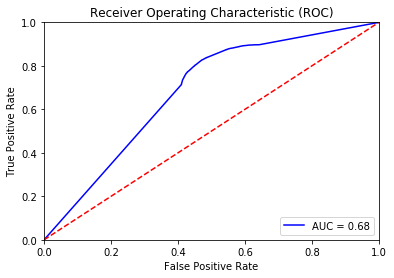

In [56]:
#### Train-Test Accuracy
train_test_acc(dt_clf,x_train,y_train,x_test,y_test)

#Metrics Calculation
metrics_cal(x_test,y_test,y_pred,dt_clf)

#ROC Curve create
roc_curve_graph(x_test,y_test,dt_clf)


### 3.3 Random Forest
Random  Forest is an ensemble learning method for classification. It selects random sample from given dataset to construct individual decision tree for each sample. Then, it predicts the result for each decision tree and perform a voiting. Prediction result with most votes is counted as the final result. Using RandomForestClassifier() library, I have applied this model on H1B dataset.

- **Result:** The **accuracy** of the model is: **74%** 
- The **confusion matrix** depicts that we have 3721+15036 = **18757** correct predictions and 4121+ 2303= **6424** incorrect predictions.
- The **precision** is: **78%**
- The **recall** is : **86%**
- The **F1-Score** score is: **0.82**
- The support is the number of occurrences of each class in y_test which is: **25181**.
- ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. In this model **Area Under the Curve** is **0.74** which is relatively better than decision tree model. **ROC-curve** shows similar indication. 

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifer
rf_model = RandomForestClassifier().fit(x_train, y_train)  

#Predict the response for test dataset
y_pred=rf_model.predict(x_test)

In [ ]:
#Train-Test Accuracy
train_test_acc(rf_model,x_train,y_train,x_test,y_test)

#Metrics Calculation
metrics_cal(x_test,y_test,y_pred,rf_model)

#ROC Curve create
roc_curve_graph(x_test,y_test,rf_model)


# 4. Result
In this section all the findings created by the above model has been accumulated. I have considered following metrics to evaluate the accuracy of model:
- Model Evaluation Metrics:
<ol>
    <li>**F1 Score:** The F1 score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. </li>
    <li>**Precision:** The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative. </li>
    <li>**Recall:** The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. </li>
    <li>**ROC Curve:** ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the ideal point where false positive rate is zero, and true positive rate is one. It means that a larger area under the curve (AUC) is usually better.
 </li>
    </ol>

<p> The following table shows the result for each model that has been applied to classify the data. According to this chart, the ** best accuracy is 75% by logistic regression model** and other two models have the same accuracy 74%. Among three models, decision tree and random forest perform quite similarly. If I consider the ROC curve to justify the model accuracy, decision tree has the worst prediction capacity. Other than that, F1 score, ROC value, Precision and Recall all these metrics indicate that logistic regression outperfoms other models.  
</p>


<img src="ResultTable.png" alt="Drawing" style="width: 800px;"/> 
                   **Fig1: Evaluation table of three models**

# 5. Conclusion and Future Work
To build a model, it is very important to extract information from dataset as much as possible. It was really time consuming to process this huge dataset like H1B. Though I have applied three models on this dataset, there is a lot of scope to improve it. 
 - Initially I down sampled the dataset to create the balance in target class. It is possible to do oversampling on this dataset. It may add more information to improve the model accuracy.
 - I have tried only three models in this case. In future, it is possible to apply K-Nearest Neighbour, Linear Discriminant Analysis and Neural Network on this dataset for better prediction.
 - It is a large dataset with huge number of category in each column. So, it is possible to add  feature selection algorithm to reduce this feature. 

# 6. Reference
1. https://www.irjet.net/archives/V5/i8/IRJET-V5I859.pdf
2. http://cs229.stanford.edu/proj2017/final-reports/5208701.pdf
3. https://scikit-learn.org/stable/modules/model_evaluation.html
4. https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
5. https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2